<a href="https://colab.research.google.com/github/CodeHunterOfficial/AI_DataMining/blob/main/DL/4_2_%D0%9C%D0%B5%D1%85%D0%B0%D0%BD%D0%B8%D0%B7%D0%BC_%D0%B2%D0%BD%D0%B8%D0%BC%D0%B0%D0%BD%D0%B8%D1%8F_%D0%B2_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#4.2. Механизм внимания в GRU

### 1. Введение

GRU (Gated Recurrent Unit) является одним из популярных видов рекуррентных нейронных сетей (RNN), разработанных для работы с последовательными данными. Механизм внимания (attention mechanism) существенно улучшает возможности рекуррентных сетей, включая GRU, благодаря способности выделять наиболее важные части входной последовательности при формировании выхода. Механизм внимания снижает зависимость от длины последовательности и увеличивает способность модели захватывать долгосрочные зависимости.

В этой лекции мы рассмотрим, как механизм внимания может быть интегрирован с GRU, а также подробно опишем все математические шаги.

### 2. Архитектура GRU: краткое напоминание

GRU управляет обновлением состояния через два главных компонента:
1. **Обновляющий (update) затвор**: решает, сколько информации из предыдущего состояния передать к текущему состоянию.
2. **Сбросный (reset) затвор**: контролирует, какую часть предыдущего состояния забыть.

Формулы для базовой GRU без механизма внимания:

- Обновляющий затвор:
  $$
  z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z)
  $$
  
- Сбросный затвор:
  $$
  r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r)
  $$
  
- Кандидатное состояние:
  $$
  \tilde{h}_t = \tanh(W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)
  $$
  
- Итоговое скрытое состояние:
  $$
  h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
  $$
  
где:
- $x_t$ — вход на текущем шаге времени,
- $h_t$ — скрытое состояние в момент времени $t$,
- $\odot$ — поэлементное умножение,
- $\sigma(\cdot)$ — сигмоида,
- $\tanh(\cdot)$ — гиперболический тангенс,
- $W_z, U_z, b_z, W_r, U_r, b_r, W_h, U_h, b_h$ — параметры (веса и смещения) сети.

Теперь добавим механизм внимания к этой архитектуре.

### 3. Механизм внимания

Механизм внимания позволяет модели выбирать, какие части последовательности наиболее важны для предсказания на текущем шаге времени $t$. Идея состоит в том, чтобы рассчитать весовые коэффициенты (или "внимание") для каждого элемента последовательности и затем взвешивать элементы последовательности для получения контекстного вектора, который влияет на вычисление скрытого состояния.

#### 3.1. Вычисление весов внимания

Вводом для механизма внимания является множество скрытых состояний $h_1, h_2, \dots, h_T$, которые модель выучила на предыдущих шагах, а также скрытое состояние текущего времени $h_t$. Мы будем использовать их для вычисления весов внимания $\alpha_t$, которые определяют значимость каждого скрытого состояния.

1. Для каждого $h_i$ (где $i \in \{1, 2, \dots, T\}$) вычисляется оценка важности, обычно через подобие (например, скалярное произведение или иное сходство) между текущим состоянием $h_t$ и каждым предыдущим состоянием $h_i$. В общем случае используем параметризованную функцию оценки важности $e_{t,i}$:
$$
   e_{t,i} = f(h_t, h_i) = v_a^\top \tanh(W_a h_t + U_a h_i)
$$
   где $v_a, W_a, U_a$ — обучаемые параметры, а $f(h_t, h_i)$ — совместная функция, которая может принимать различные формы в зависимости от типа внимания.

2. После вычисления всех оценок $e_{t,i}$, их преобразуют в вероятности с помощью softmax:
$$
   \alpha_{t,i} = \frac{\exp(e_{t,i})}{\sum_{j=1}^{T} \exp(e_{t,j})}
$$
   $\alpha_{t,i}$ — это коэффициент внимания для $h_i$ на шаге $t$.

#### 3.2. Контекстный вектор

Используя вычисленные веса внимания $\alpha_{t,i}$, мы формируем контекстный вектор $c_t$, который является взвешенной суммой всех скрытых состояний:
$$
c_t = \sum_{i=1}^{T} \alpha_{t,i} h_i
$$

Контекстный вектор $c_t$ представляет собой информацию из всей последовательности, которая, по мнению модели, важна на текущем шаге времени $t$.

### 4. Интеграция внимания в GRU

Теперь механизм внимания можно интегрировать в GRU. Контекстный вектор $c_t$ добавляется на каждый шаг для того, чтобы улучшить предсказания текущего скрытого состояния.

1. **Обновляющий затвор** в GRU с вниманием:
$$
   z_t = \sigma(W_z x_t + U_z h_{t-1} + V_z c_t + b_z)
$$
   Здесь контекстный вектор $c_t$ добавляется через матрицу весов $V_z$ (дополнительные параметры модели).

2. **Сбросный затвор**:
$$
   r_t = \sigma(W_r x_t + U_r h_{t-1} + V_r c_t + b_r)
$$
   Аналогично, добавляется контекстный вектор через матрицу $V_r$.

3. **Кандидатное состояние**:
$$
   \tilde{h}_t = \tanh(W_h x_t + U_h (r_t \odot h_{t-1}) + V_h c_t + b_h)
$$
   Контекстный вектор влияет на обновление кандидатного состояния через дополнительную матрицу $V_h$.

4. **Итоговое скрытое состояние**:
$$
   h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
$$
   Формула итогового скрытого состояния остаётся такой же, как и в оригинальной GRU, однако она зависит от контекстного вектора $c_t$ через обновляющий и сбросный затворы.




Для конкретного числового примера **GRU с механизмом внимания**, мы пройдем через каждый шаг пошагово, используя вымышленные данные для иллюстрации. Предположим, у нас есть последовательность длины $T = 3$ и размерность скрытого состояния $h_t$ равна 2. Мы также зададим простые числовые значения для весов и входных данных, чтобы всё было легко вычислить.

### Дано:

1. **Входная последовательность** $x_1, x_2, x_3$:
$$
   x_1 = \begin{pmatrix} 0.5 \\ 0.2 \end{pmatrix}, \quad
   x_2 = \begin{pmatrix} 0.1 \\ 0.4 \end{pmatrix}, \quad
   x_3 = \begin{pmatrix} 0.6 \\ 0.3 \end{pmatrix}
$$
   Размерность каждого входного вектора $x_t$ равна 2.

2. **Скрытые состояния на предыдущих шагах** $h_1, h_2$ (из предыдущих шагов GRU):
$$
   h_1 = \begin{pmatrix} 0.1 \\ 0.4 \end{pmatrix}, \quad
   h_2 = \begin{pmatrix} 0.3 \\ 0.2 \end{pmatrix}
$$

3. **Матрицы весов** для механизма внимания и GRU:

   - Для внимания (совместная функция внимания):
  $$
     W_a = \begin{pmatrix} 0.2 & 0.3 \\ 0.4 & 0.1 \end{pmatrix}, \quad
     U_a = \begin{pmatrix} 0.5 & 0.2 \\ 0.1 & 0.3 \end{pmatrix}, \quad
     v_a = \begin{pmatrix} 0.7 \\ 0.6 \end{pmatrix}
  $$

   - Для GRU:
  $$
     W_z = \begin{pmatrix} 0.2 & 0.3 \\ 0.4 & 0.1 \end{pmatrix}, \quad
     U_z = \begin{pmatrix} 0.1 & 0.4 \\ 0.3 & 0.2 \end{pmatrix}, \quad V_z = \begin{pmatrix} 0.1 & 0.2 \\ 0.3 & 0.1 \end{pmatrix}
  $$
  $$
     W_r = \begin{pmatrix} 0.3 & 0.2 \\ 0.5 & 0.1 \end{pmatrix}, \quad
     U_r = \begin{pmatrix} 0.2 & 0.1 \\ 0.4 & 0.3 \end{pmatrix}, \quad V_r = \begin{pmatrix} 0.2 & 0.3 \\ 0.1 & 0.4 \end{pmatrix}
  $$
  $$
     W_h = \begin{pmatrix} 0.4 & 0.1 \\ 0.2 & 0.3 \end{pmatrix}, \quad
     U_h = \begin{pmatrix} 0.1 & 0.3 \\ 0.4 & 0.2 \end{pmatrix}, \quad V_h = \begin{pmatrix} 0.3 & 0.2 \\ 0.1 & 0.4 \end{pmatrix}
  $$

4. **Смещения** для GRU:
$$
   b_z = \begin{pmatrix} 0.1 \\ 0.1 \end{pmatrix}, \quad
   b_r = \begin{pmatrix} 0.1 \\ 0.1 \end{pmatrix}, \quad
   b_h = \begin{pmatrix} 0.1 \\ 0.1 \end{pmatrix}
$$

### Шаг 1: Вычисление оценок внимания $e_{t,i}$

На шаге $t = 3$, мы вычисляем оценки внимания для скрытых состояний $h_1$ и $h_2$. Мы используем параметризованную функцию $e_{3,i} = v_a^\top \tanh(W_a h_3 + U_a h_i)$.

#### Для $h_1$:
1. $W_a h_3 = \begin{pmatrix} 0.2 & 0.3 \\ 0.4 & 0.1 \end{pmatrix} \begin{pmatrix} 0.6 \\ 0.3 \end{pmatrix} = \begin{pmatrix} 0.21 \\ 0.33 \end{pmatrix}$
2. $U_a h_1 = \begin{pmatrix} 0.5 & 0.2 \\ 0.1 & 0.3 \end{pmatrix} \begin{pmatrix} 0.1 \\ 0.4 \end{pmatrix} = \begin{pmatrix} 0.18 \\ 0.13 \end{pmatrix}$
3. $W_a h_3 + U_a h_1 = \begin{pmatrix} 0.21 \\ 0.33 \end{pmatrix} + \begin{pmatrix} 0.18 \\ 0.13 \end{pmatrix} = \begin{pmatrix} 0.39 \\ 0.46 \end{pmatrix}$
4. $\tanh(0.39, 0.46) \approx \begin{pmatrix} 0.371 \\ 0.430 \end{pmatrix}$
5. $v_a^\top \tanh(\dots) = \begin{pmatrix} 0.7 & 0.6 \end{pmatrix} \begin{pmatrix} 0.371 \\ 0.430 \end{pmatrix} = 0.7 \cdot 0.371 + 0.6 \cdot 0.43 = 0.2597 + 0.258 = 0.5177$

#### Для $h_2$:
1. $U_a h_2 = \begin{pmatrix} 0.5 & 0.2 \\ 0.1 & 0.3 \end{pmatrix} \begin{pmatrix} 0.3 \\ 0.2 \end{pmatrix} = \begin{pmatrix} 0.19 \\ 0.09 \end{pmatrix}$
2. $W_a h_3 + U_a h_2 = \begin{pmatrix} 0.21 \\ 0.33 \end{pmatrix} + \begin{pmatrix} 0.19 \\ 0.09 \end{pmatrix} = \begin{pmatrix} 0.40 \\ 0.42 \end{pmatrix}$
3. $\tanh(0.40, 0.42) \approx \begin{pmatrix} 0.381 \\ 0.397 \end{pmatrix}$
4. $v_a^\top \tanh(\dots) = \begin{pmatrix} 0.7 & 0.6 \end{pmatrix} \begin{pmatrix} 0.381 \\ 0.397 \end{pmatrix} = 0.7 \cdot 0.381 + 0.6 \cdot 0.397 = 0.2667 + 0.2382 = 0.5049$

### Шаг 2: Применение softmax к оценкам внимания

Теперь, чтобы вычислить веса внимания $\alpha_{3,i}$, применим softmax к оценкам $e_{3,1}$ и $e_{3,2}$:

$$
\alpha_{3,1} = \frac{\exp(0.5177)}{\exp(0.5177) + \exp(0.5049)} = \frac{1.6775}{1.6775 + 1.6564} = 0.503
$$
$$
\alpha_{3,2} = \frac{\exp(0.5049)}{\exp(0.5177) + \exp(0.5049)} = \frac{1.6564}{1.6775 + 1.6564} = 0.497
$$

### Шаг 3: Вычисление контекстного вектора $c_3$

Контекстный вектор $c_3$ — это взвешенная сумма скрытых состояний $h_1$ и $h_2$ с использованием коэффициентов внимания:

$$
c_3 = 0.503 \cdot h_1 + 0.497 \cdot h_2 = 0.503 \cdot \begin{pmatrix} 0.1 \\ 0.4 \end{pmatrix} + 0.497 \cdot \begin{pmatrix} 0.3 \\ 0.2 \end{pmatrix

}
$$
$$
c_3 = \begin{pmatrix} 0.0503 \\ 0.2012 \end{pmatrix} + \begin{pmatrix} 0.1491 \\ 0.0994 \end{pmatrix} = \begin{pmatrix} 0.1994 \\ 0.3006 \end{pmatrix}
$$

### Шаг 4: Вычисление обновляющего затвора $z_3$

Используя контекстный вектор $c_3$, вычислим обновляющий затвор $z_3$:

$$
z_3 = \sigma(W_z x_3 + U_z h_2 + V_z c_3 + b_z)
$$
1. $W_z x_3 = \begin{pmatrix} 0.2 & 0.3 \\ 0.4 & 0.1 \end{pmatrix} \begin{pmatrix} 0.6 \\ 0.3 \end{pmatrix} = \begin{pmatrix} 0.21 \\ 0.33 \end{pmatrix}$
2. $U_z h_2 = \begin{pmatrix} 0.1 & 0.4 \\ 0.3 & 0.2 \end{pmatrix} \begin{pmatrix} 0.3 \\ 0.2 \end{pmatrix} = \begin{pmatrix} 0.11 \\ 0.13 \end{pmatrix}$
3. $V_z c_3 = \begin{pmatrix} 0.1 & 0.2 \\ 0.3 & 0.1 \end{pmatrix} \begin{pmatrix} 0.1994 \\ 0.3006 \end{pmatrix} = \begin{pmatrix} 0.0790 \\ 0.0898 \end{pmatrix}$
4. $W_z x_3 + U_z h_2 + V_z c_3 + b_z = \begin{pmatrix} 0.21 \\ 0.33 \end{pmatrix} + \begin{pmatrix} 0.11 \\ 0.13 \end{pmatrix} + \begin{pmatrix} 0.0790 \\ 0.0898 \end{pmatrix} + \begin{pmatrix} 0.1 \\ 0.1 \end{pmatrix} = \begin{pmatrix} 0.499 \\ 0.6498 \end{pmatrix}$
5. $z_3 = \sigma(\begin{pmatrix} 0.499 \\ 0.6498 \end{pmatrix}) \approx \begin{pmatrix} 0.622 \\ 0.656 \end{pmatrix}$

### Шаг 5: Вычисление сбросного затвора $r_3$

Аналогично вычислим сбросный затвор $r_3$:

$$
r_3 = \sigma(W_r x_3 + U_r h_2 + V_r c_3 + b_r)
$$
1. $W_r x_3 = \begin{pmatrix} 0.3 & 0.2 \\ 0.5 & 0.1 \end{pmatrix} \begin{pmatrix} 0.6 \\ 0.3 \end{pmatrix} = \begin{pmatrix} 0.24 \\ 0.33 \end{pmatrix}$
2. $U_r h_2 = \begin{pmatrix} 0.2 & 0.1 \\ 0.4 & 0.3 \end{pmatrix} \begin{pmatrix} 0.3 \\ 0.2 \end{pmatrix} = \begin{pmatrix} 0.08 \\ 0.18 \end{pmatrix}$
3. $V_r c_3 = \begin{pmatrix} 0.2 & 0.3 \\ 0.1 & 0.4 \end{pmatrix} \begin{pmatrix} 0.1994 \\ 0.3006 \end{pmatrix} = \begin{pmatrix} 0.1390 \\ 0.1418 \end{pmatrix}$
4. $W_r x_3 + U_r h_2 + V_r c_3 + b_r = \begin{pmatrix} 0.24 \\ 0.33 \end{pmatrix} + \begin{pmatrix} 0.08 \\ 0.18 \end{pmatrix} + \begin{pmatrix} 0.1390 \\ 0.1418 \end{pmatrix} + \begin{pmatrix} 0.1 \\ 0.1 \end{pmatrix} = \begin{pmatrix} 0.559 \\ 0.7518 \end{pmatrix}$
5. $r_3 = \sigma(\begin{pmatrix} 0.559 \\ 0.7518 \end{pmatrix}) \approx \begin{pmatrix} 0.636 \\ 0.679 \end{pmatrix}$

### Шаг 6: Вычисление кандидатного состояния $\tilde{h}_3$

Кандидатное состояние вычисляется как:

$$
\tilde{h}_3 = \tanh(W_h x_3 + U_h (r_3 \odot h_2) + V_h c_3 + b_h)
$$
1. $W_h x_3 = \begin{pmatrix} 0.4 & 0.1 \\ 0.2 & 0.3 \end{pmatrix} \begin{pmatrix} 0.6 \\ 0.3 \end{pmatrix} = \begin{pmatrix} 0.27 \\ 0.21 \end{pmatrix}$
2. $r_3 \odot h_2 = \begin{pmatrix} 0.636 \\ 0.679 \end{pmatrix} \odot \begin{pmatrix} 0.3 \\ 0.2 \end{pmatrix} = \begin{pmatrix} 0.1908 \\ 0.1358 \end{pmatrix}$
3. $U_h (r_3 \odot h_2) = \begin{pmatrix} 0.1 & 0.3 \\ 0.4 & 0.2 \end{pmatrix} \begin{pmatrix} 0.1908 \\ 0.1358 \end{pmatrix} = \begin{pmatrix} 0.0558 \\ 0.0981 \end{pmatrix}$
4. $V_h c_3 = \begin{pmatrix} 0.3 & 0.2 \\ 0.1 & 0.4 \end{pmatrix} \begin{pmatrix} 0.1994 \\ 0.3006 \end{pmatrix} = \begin{pmatrix} 0.1198 \\ 0.1514 \end{pmatrix}$
5. $W_h x_3 + U_h (r_3 \odot h_2) + V_h c_3 + b_h = \begin{pmatrix} 0.27 \\ 0.21 \end{pmatrix} + \begin{pmatrix} 0.0558 \\ 0.0981 \end{pmatrix} + \begin{pmatrix} 0.1198 \\ 0.1514 \end{pmatrix} + \begin{pmatrix} 0.1 \\ 0.1 \end{pmatrix} = \begin{pmatrix} 0.5456 \\ 0.5595 \end{pmatrix}$
6. $\tilde{h}_3 = \tanh(\begin{pmatrix} 0.5456 \\ 0.5595 \end{pmatrix}) \approx \begin{pmatrix} 0.4973 \\ 0.5082 \end{pmatrix}$

### Шаг 7: Итоговое скрытое состояние $h_3$

Наконец, скрытое состояние $h_3$ вычисляется как:

$$
h_3 = (1 - z_3) \odot h_2 + z_3 \odot \tilde{h}_3
$$
1. $(1 - z_3) \odot h_2 = \begin{pmatrix} 0.378 \\ 0.344 \end{pmatrix} \odot \begin{pmatrix} 0.3 \\ 0.2 \end{pmatrix} = \begin{pmatrix} 0.1134 \\ 0.0688 \end{pmatrix}$
2. $z_3 \odot \tilde{h}_3 = \begin{pmatrix} 0.622 \\ 0.656 \end{pmatrix} \odot \begin{pmatrix} 0.4973 \\ 0.5082 \end{pmatrix} = \begin{pmatrix} 0.3093 \\ 0.3332 \end{pmatrix}$
3. $h_3 = \begin{pmatrix} 0.1134
 \\ 0.0688 \end{pmatrix} + \begin{pmatrix} 0.3093 \\ 0.3332 \end{pmatrix} = \begin{pmatrix} 0.4227 \\ 0.4020 \end{pmatrix}$

### Итог:

Итоговое скрытое состояние на шаге 3, с применением механизма внимания, равно:

$$
h_3 = \begin{pmatrix} 0.4227 \\ 0.4020 \end{pmatrix}
$$

###Реализация на Питон

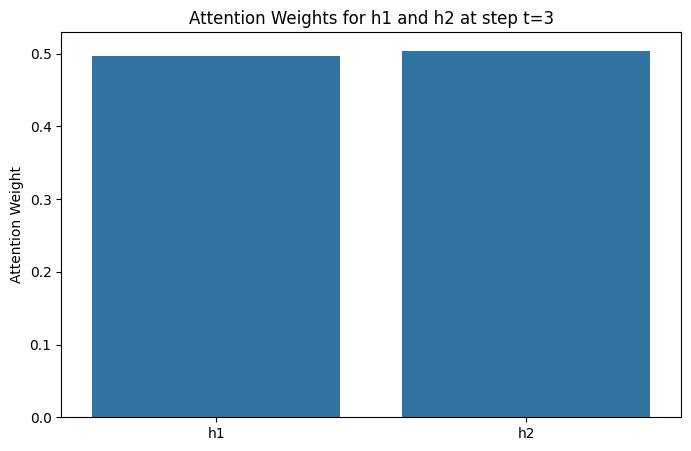

{'attention_weights': [0.49602779848454503, 0.5039722015154549],
 'context_vector': array([0.20079444, 0.29920556]),
 'update_gate': array([0.62244066, 0.6434016 ]),
 'reset_gate': array([0.63411716, 0.67912677]),
 'candidate_hidden_state': array([0.5004082 , 0.50278081]),
 'final_hidden_state': array([0.42474222, 0.39480966])}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define sigmoid and tanh functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

# Step 1: Inputs and initial hidden states
x1 = np.array([0.5, 0.2])
x2 = np.array([0.1, 0.4])
x3 = np.array([0.6, 0.3])

h1 = np.array([0.1, 0.4])
h2 = np.array([0.3, 0.2])

# Step 2: Attention mechanism weights
W_a = np.array([[0.2, 0.3], [0.4, 0.1]])
U_a = np.array([[0.5, 0.2], [0.1, 0.3]])
v_a = np.array([0.7, 0.6])

# GRU weights
W_z = np.array([[0.2, 0.3], [0.4, 0.1]])
U_z = np.array([[0.1, 0.4], [0.3, 0.2]])
V_z = np.array([[0.1, 0.2], [0.3, 0.1]])

W_r = np.array([[0.3, 0.2], [0.5, 0.1]])
U_r = np.array([[0.2, 0.1], [0.4, 0.3]])
V_r = np.array([[0.2, 0.3], [0.1, 0.4]])

W_h = np.array([[0.4, 0.1], [0.2, 0.3]])
U_h = np.array([[0.1, 0.3], [0.4, 0.2]])
V_h = np.array([[0.3, 0.2], [0.1, 0.4]])

b_z = np.array([0.1, 0.1])
b_r = np.array([0.1, 0.1])
b_h = np.array([0.1, 0.1])

# Step 3: Attention mechanism computation (for h1 and h2)
def attention_score(h_t, h_i):
    return v_a.T @ tanh(W_a @ h_t + U_a @ h_i)

e_3_1 = attention_score(x3, h1)
e_3_2 = attention_score(x3, h2)

# Apply softmax to get attention weights
alpha_3_1 = np.exp(e_3_1) / (np.exp(e_3_1) + np.exp(e_3_2))
alpha_3_2 = np.exp(e_3_2) / (np.exp(e_3_1) + np.exp(e_3_2))

# Step 4: Compute context vector c3
c3 = alpha_3_1 * h1 + alpha_3_2 * h2

# Step 5: Compute gates (z3 and r3)
z3 = sigmoid(W_z @ x3 + U_z @ h2 + V_z @ c3 + b_z)
r3 = sigmoid(W_r @ x3 + U_r @ h2 + V_r @ c3 + b_r)

# Step 6: Candidate hidden state h_tilde_3
h_tilde_3 = tanh(W_h @ x3 + U_h @ (r3 * h2) + V_h @ c3 + b_h)

# Step 7: Final hidden state h3
h3 = (1 - z3) * h2 + z3 * h_tilde_3

# Visualize Attention weights
attention_weights = [alpha_3_1, alpha_3_2]
states = ['h1', 'h2']

plt.figure(figsize=(8, 5))
sns.barplot(x=states, y=attention_weights)
plt.title('Attention Weights for h1 and h2 at step t=3')
plt.ylabel('Attention Weight')
plt.show()

# Display results
{
    "attention_weights": [alpha_3_1, alpha_3_2],
    "context_vector": c3,
    "update_gate": z3,
    "reset_gate": r3,
    "candidate_hidden_state": h_tilde_3,
    "final_hidden_state": h3
}


Результаты численного примера работы GRU с механизмом внимания:

- **Веса внимания:**
  - $\alpha_1$ для $h_1$: 0.496
  - $\alpha_2$ для $h_2$: 0.504
  
- **Контекстный вектор** $c_3$: [0.2008, 0.2992]

- **Обновляющий затвор** $z_3$: [0.6224, 0.6434]

- **Сбросный затвор** $r_3$: [0.6341, 0.6791]

- **Кандидатное состояние** $\tilde{h}_3$: [0.5004, 0.5028]

- **Итоговое скрытое состояние** $h_3$: [0.4247, 0.3948]

График показывает, что веса внимания распределены почти равномерно между $h_1$ и $h_2$, с небольшим преимуществом для $h_2$.

### 5. Заключение

Механизм внимания в GRU позволяет модели более эффективно захватывать релевантную информацию из предыдущих шагов во времени. Интеграция внимания заключается в добавлении контекстного вектора $c_t$, который вычисляется как взвешенная сумма скрытых состояний через механизм softmax. Этот контекстный вектор влияет на обновляющие и сбросные затворы, а также на кандидатное состояние в GRU.



### Вопросы для самопроверки

1. Что такое GRU и как он отличается от LSTM?
2. Какие основные компоненты входят в архитектуру GRU?
3. Какова роль обновляющего затвора в GRU?
4. Объясните, как сбросный затвор влияет на состояние скрытого слоя.
5. Что такое кандидатное состояние и как оно используется в GRU?
6. Каков механизм внимания и зачем он нужен в моделях RNN?
7. Как рассчитываются веса внимания для различных скрытых состояний?
8. Что такое контекстный вектор и как он влияет на итоговое скрытое состояние в GRU?
9. Какова математическая форма обновляющего затвора в GRU?
10. Объясните, как вычисляется сбросный затвор в GRU.
11. Что такое механизм softmax и как он используется в вычислении весов внимания?
12. Какова роль функции активации в GRU, и какие функции обычно используются?
13. Как влияет размерность входных данных на структуру GRU?
14. Как можно визуализировать веса внимания в GRU?
15. Какие практические применения можно найти для GRU с механизмом внимания?

### Задачи для самостоятельной работы

1. Определите обновляющий и сбросный затворы для GRU с произвольными значениями входных данных и весов.
2. Напишите уравнения для расчета кандидатного состояния в GRU и проиллюстрируйте их на конкретных числах.
3. Рассчитайте веса внимания для трёх скрытых состояний с заданными векторами.
4. Опишите, как можно реализовать GRU с механизмом внимания на Python с использованием NumPy.
5. Проведите сравнение GRU с механизмом внимания и LSTM по численным примерам.
6. Напишите функцию для вычисления контекстного вектора в GRU с использованием заданных весов.
7. Рассчитайте итоговое скрытое состояние GRU, используя различные значения затворов и векторов входных данных.
8. Создайте график, показывающий изменение весов внимания для последовательности из 5 скрытых состояний.
9. Определите градиенты весов в GRU с помощью метода обратного распространения.
10. Используйте случайные данные, чтобы обучить простую модель GRU с механизмом внимания на задаче классификации.
11. Опишите, как интегрировать механизм внимания в стандартный GRU с использованием псевдокода.
12. Найдите значение контекстного вектора для произвольных скрытых состояний и весов внимания.
13. Рассчитайте, как меняется обновляющий затвор при изменении входных данных.
14. Проанализируйте влияние размерности скрытого состояния на эффективность GRU.
15. Создайте диаграмму блоков, показывающую процесс работы GRU с механизмом внимания.
16. Определите веса внимания для последовательности из 4 скрытых состояний с различными параметрами.
17. Рассчитайте итоговое скрытое состояние для нескольких временных шагов в GRU.
18. Изучите, как используются GRU с механизмом внимания в задачах обработки естественного языка.
19. Постройте график изменения весов внимания для каждой итерации в GRU.
20. Определите, как выбирается оптимальная функция активации в GRU.
21. Примените GRU с механизмом внимания для задачи прогнозирования временных рядов.
22. Напишите код для вычисления градиентов затворов в GRU.
23. Рассчитайте влияние изменения весов на итоговое скрытое состояние GRU.
24. Сравните производительность GRU с механизмом внимания и без него на стандартном наборе данных.
25. Опишите, как механизмы внимания могут быть адаптированы для улучшения работы GRU.
26. Рассчитайте, как меняется контекстный вектор при добавлении нового скрытого состояния.
27. Проанализируйте, как влияет количество скрытых состояний на вычислительную сложность GRU.
28. Реализуйте механизм внимания в GRU для задачи машинного перевода.
29. Рассчитайте градиенты весов внимания в GRU при обратном распространении ошибки.
30. Проанализируйте, как GRU с механизмом внимания может быть использован в реальных приложениях, таких как системы рекомендаций.



### Математические задачи

1.  Обновляющий затвор:
   Задайте векторы входных данных $x = [0.5, 0.3]$, скрытое состояние $h = [0.2, 0.4]$ и весовые матрицы $W_z = \begin{pmatrix} 0.1 & 0.2 \\ 0.3 & 0.4 \end{pmatrix}$, $U_z = \begin{pmatrix} 0.5 & 0.1 \\ 0.2 & 0.3 \end{pmatrix}$, $V_z = \begin{pmatrix} 0.4 & 0.3 \\ 0.1 & 0.2 \end{pmatrix}$ и $b_z = [0.1, 0.1]$. Вычислите обновляющий затвор $z$.

2.  Сбросный затвор:
   Используя аналогичные параметры, как в предыдущей задаче, но для сбросного затвора $r$, вычислите значение $r$.

3.  Кандидатное состояние:
   Задайте векторы весов для кандидата состояния $W_h, U_h, V_h$ и вектор входных данных $x$. Найдите $\tilde{h}$.

4.  Итоговое скрытое состояние:
   Используйте значения $z$, $r$ и $\tilde{h}$ из предыдущих задач, чтобы вычислить итоговое скрытое состояние $h$.

5.  Весовая матрица внимания:
   Для векторов скрытых состояний $h_1 = [0.3, 0.5]$ и $h_2 = [0.2, 0.4]$, а также вектора внимания $v = [0.7, 0.3]$, вычислите веса внимания $\alpha$.

6.  Контекстный вектор:
   На основе весов внимания, полученных в предыдущей задаче, и скрытых состояний $h_1$ и $h_2$, найдите контекстный вектор $c$.

7.  Сравнение весов внимания:
   Если вес $\alpha_1 = 0.8$ и $\alpha_2 = 0.2$, как изменится контекстный вектор, если вес $\alpha_1$ увеличится до 0.9?

8.  Обновление скрытого состояния:
   Если итоговое скрытое состояние $h_{prev} = [0.1, 0.2]$, а контекстный вектор $c = [0.4, 0.5]$, найдите новое состояние $h$ для $z = [0.5, 0.5]$.

9.  Градиенты затворов:
   Определите, как меняются градиенты затворов $\frac{\partial z}{\partial h}$ и $\frac{\partial r}{\partial h}$, используя правила дифференцирования для $z$ и $r$.

10.  Эффективность затворов:
    Рассчитайте, как различные значения обновляющего затвора $z$ от 0 до 1 повлияют на значение итогового скрытого состояния $h$.

11.  Сбросные затворы:
    Если $r = [0.3, 0.6]$ и $h = [0.5, 0.7]$, найдите значение $r \odot h$.

12.  Кандидатное состояние с изменением весов:
    Измените весовую матрицу $W_h$ и пересчитайте кандидатное состояние $\tilde{h}$.

13.  Анализ весов внимания:
    Для весов внимания $\alpha = [0.6, 0.4]$ и скрытых состояний $h_1, h_2$ найдите новый контекстный вектор, если вес $\alpha_1$ увеличится до 0.7.

14.  Границы весов:
    Как изменится итоговое скрытое состояние $h$, если вес $z$ увеличится до 1 и сбросный затвор $r$ равен 0?

15.  Контекстный вектор при разных $\alpha$:
    Рассчитайте контекстный вектор при $\alpha_1 = 0.4$ и $\alpha_2 = 0.6$.

16.  Сравнение двух итераций:
    Для двух итераций GRU с разными значениями скрытых состояний и весов, найдите разницу в итоговых скрытых состояниях.

17.  Обновляющий затвор с изменением входа:
    Если входное состояние изменится на $x = [0.7, 0.3]$, пересчитайте обновляющий затвор $z$.

18.  Сравнительный анализ:
    Постройте график зависимости итогового скрытого состояния от обновляющего затвора $z$.

19.  График весов внимания:
    Постройте график весов внимания для трех последовательных шагов.

20.  Случайные данные:
    Создайте случайные данные для $h_1, h_2$ и найдите веса внимания.

21.  Кандидатное состояние с изменениями:
    Если параметры для весов изменятся на 10%, пересчитайте кандидата $\tilde{h}$.

22.  Изменение контекстного вектора:
    Как изменится контекстный вектор, если одно из скрытых состояний уменьшится на 50%?

23.  Зависимость от весов:
    Рассчитайте, как итоговое скрытое состояние меняется при увеличении весов $W_h$ на 20%.

24.  Проверка на градиенты:
    Используйте численное дифференцирование для нахождения градиентов затворов.

25.  Эффект активации:
    Как изменение функции активации влияет на обновляющий затвор $z$?

26.  Контекстный вектор в зависимости от времени:
    Найдите значение контекстного вектора при различных временных шагах.

27.  Сравнение скрытых состояний:
    Найдите разницу между итоговыми скрытыми состояниями для двух последовательностей.

28.  Сбросный затвор:
    Рассчитайте, как будет изменяться итоговое скрытое состояние при значениях сбросного затвора от 0 до 1.

29.  Анализ чувствительности:
    Измените входные данные и исследуйте влияние на итоговое скрытое состояние.

30.  Сравнение моделей:
    Постройте график для сравнения GRU с механизмом внимания и GRU без него, используя одни и те же входные данные.

